In [1]:
import pandas as pd
import torch
from torch import nn 
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 
from sklearn.metrics import accuracy_score
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os
import shutil
import PIL
import cv2
from tqdm import tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
input_dir = '/kaggle/input/yikes-spiders-15-species'  
output_dir = '/kaggle/working/'  

In [126]:
shutil.rmtree("/kaggle/working/train")    
shutil.rmtree("/kaggle/working/val")         
shutil.rmtree("/kaggle/working/test")

In [5]:
def copy_structure(src, dest):
    if not os.path.exists(dest):
        os.makedirs(dest)
    
    for dirpath, dirnames, filenames in os.walk(src):
        dest_path = dirpath.replace(src, dest, 1)
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        
        for filename in tqdm(filenames):
            src_file = os.path.join(dirpath, filename)
            dest_file = os.path.join(dest_path, filename)
            shutil.copy2(src_file, dest_file)


In [6]:
copy_structure(os.path.join(input_dir, 'train'), os.path.join(output_dir, 'train'))
copy_structure(os.path.join(input_dir, 'test'), os.path.join(output_dir, 'test'))
copy_structure(os.path.join(input_dir, 'valid'), os.path.join(output_dir, 'val'))

0it [00:00, ?it/s]
100%|██████████| 154/154 [00:01<00:00, 151.02it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 168.82it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 176.00it/s]


In [7]:
train_data_link = "/kaggle/working/train"
val_data_link = "/kaggle/working/val"
test_data_link = "/kaggle/working/test"

train_data = pathlib.Path(train_data_link)
val_data = pathlib.Path(val_data_link)
test_data = pathlib.Path(test_data_link)

In [8]:
import os
from PIL import Image
import shutil

dir_ = '/kaggle/working/val'
num_copies = 3


for folder_name in os.listdir(dir_):
    folder_path = os.path.join(dir_, folder_name)
    if os.path.isdir(folder_path):

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                for i in range(1, num_copies + 1):
                    new_file_path = os.path.join(folder_path, f'{filename[:-4]}_copy_{i}.jpg')
                    shutil.copy(file_path, new_file_path)



In [9]:
import os
from PIL import Image
import shutil

dir_ = '/kaggle/working/train'
num_copies = 1


for folder_name in os.listdir(dir_):
    folder_path = os.path.join(dir_, folder_name)
    if os.path.isdir(folder_path):

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                for i in range(1, num_copies + 1):
                    new_file_path = os.path.join(folder_path, f'{filename[:-4]}_copy_{i}.jpg')
                    shutil.copy(file_path, new_file_path)



In [ ]:
list(train_data.glob("Black Widow/*"))

In [11]:
list_of_classes = os.listdir(train_data_link)
list_of_classes

['Black Widow',
 'Ladybird Mimic Spider',
 'Blue Tarantula',
 'Bold Jumper',
 'Deinopis Spider',
 'Peacock Spider',
 'White Kneed Tarantula',
 'Yellow Garden Spider',
 'Spiny-backed Orb-weaver',
 'Huntsman Spider',
 'Brown Recluse Spider',
 'Golden Orb Weaver',
 'Hobo Spider',
 'Brown Grass Spider',
 'Red Knee Tarantula']

In [12]:
def create_dict(lst, data):
    dictionary = {}
    for obj in lst:
        t_list = list(data.glob(f"{obj}/*"))
        dictionary[obj] = t_list
    return dictionary

In [13]:
train_dict = create_dict(list_of_classes, train_data)
val_dict = create_dict(list_of_classes, val_data)
test_dict = create_dict(list_of_classes, test_data)

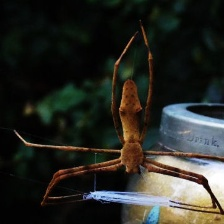

In [14]:
PIL.Image.open(str(train_dict["Deinopis Spider"][0]))

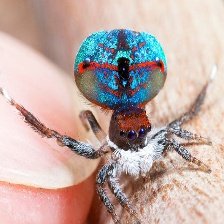

In [15]:
PIL.Image.open(str(train_dict["Peacock Spider"][0]))

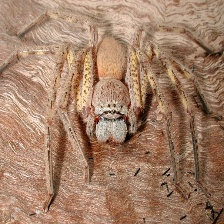

In [16]:
PIL.Image.open(str(train_dict["Huntsman Spider"][0]))

In [17]:
venomous_dict = {}

for obj in list_of_classes:
    if obj in ["Black Widow", "Brown Recluse Spider", "Hobo Spider"]:
        venomous_dict[obj] = 0
    elif obj in ["Golden Orb Weaver", "Huntsman Spider", "White Kneed Tarantula", "Red Knee Tarantula", "Blue Tarantula", "Spiny-backed Orb-weaver", "Blue Tarantula"]:
        venomous_dict[obj] = 1
    elif obj in ["Bold Jumper", "Deinopis Spider", "Ladybird Mimic Spider", "Peacock Spider", "Yellow Garden Spider", "Brown Grass Spider"]:
        venomous_dict[obj] = 2
        

classes_dict = {}

for num, obj in enumerate(list_of_classes):
    classes_dict[obj] = num
    


In [18]:
venomous_dict

{'Black Widow': 0,
 'Ladybird Mimic Spider': 2,
 'Blue Tarantula': 1,
 'Bold Jumper': 2,
 'Deinopis Spider': 2,
 'Peacock Spider': 2,
 'White Kneed Tarantula': 1,
 'Yellow Garden Spider': 2,
 'Spiny-backed Orb-weaver': 1,
 'Huntsman Spider': 1,
 'Brown Recluse Spider': 0,
 'Golden Orb Weaver': 1,
 'Hobo Spider': 0,
 'Brown Grass Spider': 2,
 'Red Knee Tarantula': 1}

In [19]:
classes_dict

{'Black Widow': 0,
 'Ladybird Mimic Spider': 1,
 'Blue Tarantula': 2,
 'Bold Jumper': 3,
 'Deinopis Spider': 4,
 'Peacock Spider': 5,
 'White Kneed Tarantula': 6,
 'Yellow Garden Spider': 7,
 'Spiny-backed Orb-weaver': 8,
 'Huntsman Spider': 9,
 'Brown Recluse Spider': 10,
 'Golden Orb Weaver': 11,
 'Hobo Spider': 12,
 'Brown Grass Spider': 13,
 'Red Knee Tarantula': 14}

In [20]:
def split_data(features_dict, label1_dict, label2_dict):
    x = []
    y1 = []
    y2 = []
    
    for name, images in features_dict.items():
        for image in images:
            image = cv2.imread(str(image))
            t_resized_image = cv2.resize(image, (256, 256))
            x.append(t_resized_image)
            y1.append(label1_dict[name])
            y2.append(label2_dict[name])
            
    return x, (y1, y2)

In [21]:
x_train, y_train = split_data(train_dict, classes_dict, venomous_dict)
x_val, y_val = split_data(val_dict, classes_dict, venomous_dict)
x_test, y_test = split_data(test_dict, classes_dict, venomous_dict)

In [22]:
danger_level = ["high", "meduim", "low"]

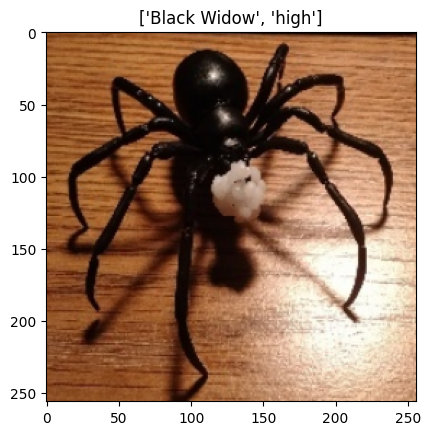

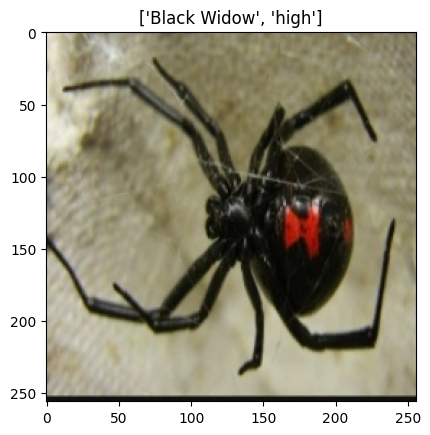

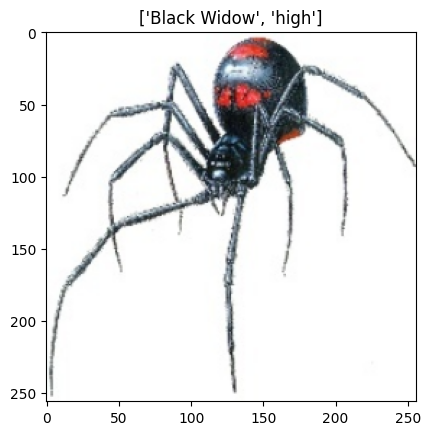

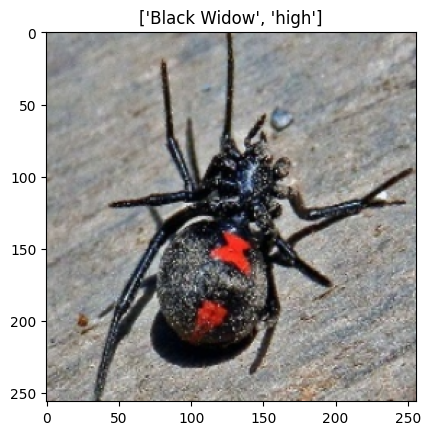

In [23]:
def output(x, y, num, lst1, lst2):
    for i in range(num):
        x[i] = cv2.cvtColor(x[i], cv2.COLOR_RGB2BGR)
        plt.imshow(x[i])
        plt.title([lst1[y[0][i]], lst2[y[1][i]]])
        plt.show()
        

output(x_train, y_train, 4, list_of_classes, danger_level)

In [24]:
train_transform = transforms.Compose([   
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))

])



val_transform = transforms.Compose([   
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [25]:
len(x_val), len(x_train)

(300, 4370)

In [26]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform):
        self.x_data = x_data
        self.y_data_class = torch.LongTensor(y_data[0]) 
        self.y_data_poisonous = torch.LongTensor(y_data[1])  
        self.transform = transform
       
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):        
        x = self.x_data[idx]
        x = x.astype(np.float32)
        x = x / 255.0
        
        if self.transform:
            x = self.transform(x)
        
        y_class = self.y_data_class[idx]
        y_poisonous = self.y_data_poisonous[idx]
        
        return x, (y_class, y_poisonous)

In [27]:
train_dataset = CustomDataset(x_train, y_train, transform = train_transform)
val_dataset = CustomDataset(x_val, y_val, transform = val_transform)
test_dataset = CustomDataset(x_test, y_test, transform = test_transform)

In [28]:
len(train_dataset)

4370

In [29]:
x, y = train_dataset[398]
x, y

(tensor([[[-0.3369, -0.3369, -0.3369,  ..., -0.2171, -0.2684, -0.2684],
          [-0.3369, -0.3369, -0.3369,  ..., -0.2171, -0.2513, -0.2684],
          [-0.3369, -0.3369, -0.3369,  ..., -0.2171, -0.2513, -0.2513],
          ...,
          [ 0.5707,  0.4851,  0.4679,  ..., -0.1314,  0.0056, -0.2513],
          [ 0.6049,  0.5022,  0.4679,  ..., -0.0116, -0.1657, -0.0629],
          [ 0.6392,  0.4851,  0.4679,  ...,  0.1254, -0.1657, -0.1314]],
 
         [[ 1.1681,  1.1681,  1.1681,  ...,  1.3606,  1.3431,  1.3431],
          [ 1.1681,  1.1681,  1.1681,  ...,  1.3606,  1.3431,  1.3431],
          [ 1.1681,  1.1681,  1.1681,  ...,  1.3606,  1.3431,  1.3431],
          ...,
          [ 1.8859,  1.8333,  1.9034,  ...,  1.5007,  1.6758,  1.4132],
          [ 1.9034,  1.8333,  1.9034,  ...,  1.5707,  1.4132,  1.5182],
          [ 1.9034,  1.8158,  1.8859,  ...,  1.6933,  1.3957,  1.4307]],
 
         [[ 0.2871,  0.2871,  0.2871,  ...,  0.5485,  0.5485,  0.5485],
          [ 0.2871,  0.2871,

In [30]:
for i in range(15):
    x, y = train_dataset[i]
    print(x.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


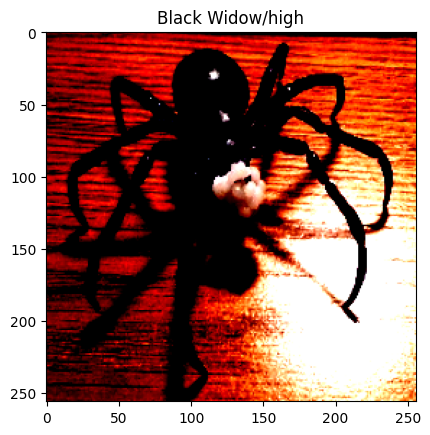

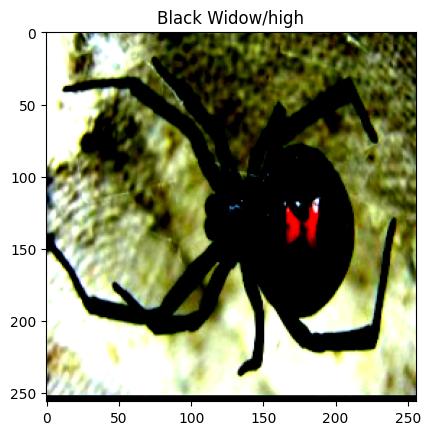

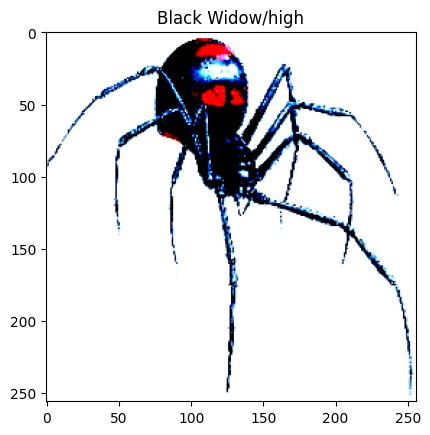

In [31]:
def output(dataset, itterations, names_list):
    for i in range(itterations):
        img, label = dataset[i]
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        plt.title(names_list[label[0]] + "/" + danger_level[label[1]])
        plt.imshow(img)
        plt.show()
        
        
output(train_dataset, 3, list_of_classes)   

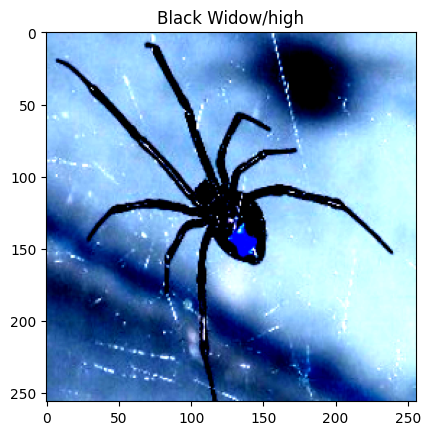

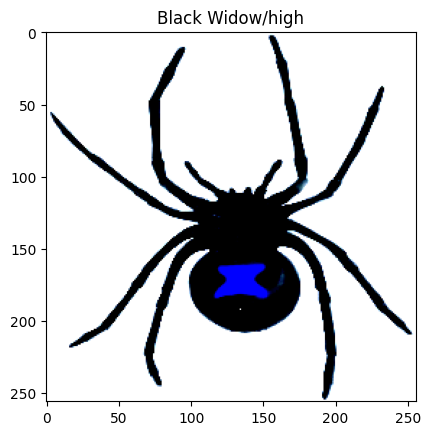

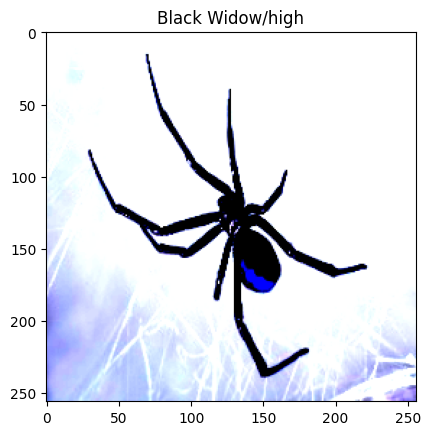

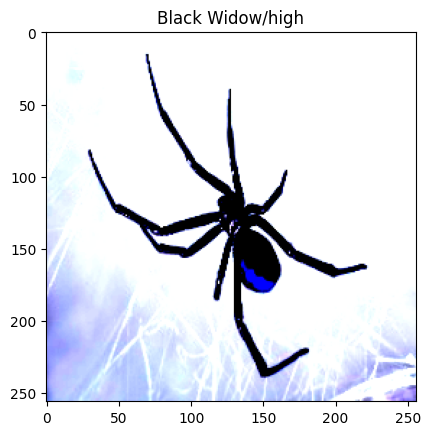

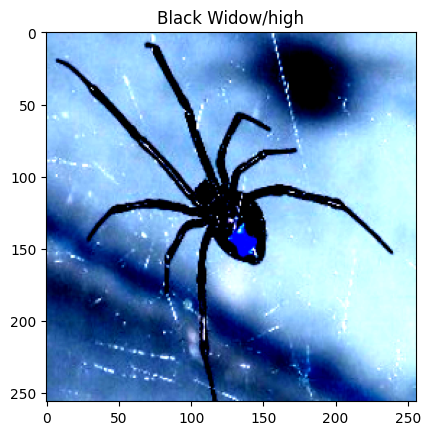

In [32]:
output(val_dataset, 5, list_of_classes)

In [33]:
bacth_size = 16

train_loader = DataLoader(
    train_dataset,              
    batch_size=bacth_size,        
    shuffle=True       
)

val_loader = DataLoader(
    val_dataset,              
    batch_size=bacth_size,        
    shuffle=True         
)

test_loader = DataLoader(
    test_dataset,              
    batch_size=64,        
    shuffle=True         
)

In [34]:
x, y = next(iter(test_loader))
len(x)

64

In [35]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, additional_conv = False, additional_pooling = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding=1)
        
        if additional_conv == True:
            self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding=1)
        
        else:
            self.conv2 = None
        
        
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        if additional_pooling == True:
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        else: 
            self.pool2 = None 
            
    def forward(self, x):
        out = self.conv1(x)
        
        if self.conv2 is not None:
            out = F.relu(out)
            out = self.conv2(out)
            
        out = F.relu(out)
        
        out = self.pool1(out)
        out = F.relu(out)
        
        if self.pool2 is not None:
            out = self.pool2(out)
            out = F.relu(out)
        
        return out 
        

In [38]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_value=None, bnorm=False, output_layer=False):
        super().__init__()
        
        self.linear = nn.Linear(in_features, out_features)
        
        if dropout_value is not None:
            self.dropout = nn.Dropout(dropout_value)
        else:
            self.dropout = None
        
        if bnorm:
            self.bnorm = nn.BatchNorm1d(out_features)
        else:
            self.bnorm = None
        
        self.output_layer = output_layer
    
    def forward(self, x):
        out = self.linear(x)
        
        if self.bnorm is not None:
            out = self.bnorm(out)
        
        out = F.relu(out)
        
        if not self.output_layer and self.dropout is not None:
            out = self.dropout(out)

        
        return out


In [39]:
import torchvision.models as models


class CustomNetwork(nn.Module):
    def __init__(self, spider_classes = 15, venomous_levels = 3):
        super().__init__()
#         3, 256, 256
        self.conv_block1 = ConvBlock(3, 32, additional_pooling = True)
#         32, 64, 64
        self.conv_block2 = ConvBlock(32, 64, additional_pooling = False)
#         64, 16, 16
        self.conv_block3 = ConvBlock(64, 128, additional_pooling = False)
#         128, 4, 4 
        self.conv_block4 = ConvBlock(128, 256, additional_pooling = True)
#         256, 2, 2 
        self.conv_block5 = ConvBlock(256, 512, additional_pooling = True)
#         512, 1, 1
        self.flatten = nn.Flatten()
    
#       --------------------------------------------------------------------------------------------------------
        
    
        self.linear_block1_1 = LinearBlock(512, 256, dropout_value = 0.3, bnorm=True)
            
        self.linear_block1_2 = LinearBlock(256, 64, dropout_value = 0.3, bnorm=True)
        
        self.linear_block1_3 = LinearBlock(64, 32, dropout_value = 0.2, bnorm=True) 
        
        self.linear_block1_4 = LinearBlock(32, spider_classes, output_layer = True)
        
#       --------------------------------------------------------------------------------------------------------
        
        self.linear_block2_1 = LinearBlock(512, 256, dropout_value = 0.3, bnorm=True)
        
        self.linear_block2_2 = LinearBlock(256, 64, dropout_value = 0.3, bnorm=True)
        
        self.linear_block2_3 = LinearBlock(64, 32, dropout_value = 0.2, bnorm=True)
        
        self.linear_block2_4 = LinearBlock(32, 8, dropout_value = None, bnorm=True)
        
        self.linear_block2_5 = LinearBlock(8, venomous_levels, output_layer = True)
        
    
    def forward(self, x):
#         print(x.size())
        out = self.conv_block1(x)
#         print(out.size())
        out = self.conv_block2(out)
#         print(out.size())
        out = self.conv_block3(out)
#         print(out.size())
        out = self.conv_block4(out)
#         print(out.size())
        out = self.conv_block5(out)
#         print(out.size())
     

        fin_out = self.flatten(out)


        x1 = self.linear_block1_1(fin_out)
        x1 = self.linear_block1_2(x1)
        x1 = self.linear_block1_3(x1)
        out1 = self.linear_block1_4(x1)

        x2 = self.linear_block2_1(fin_out)
        x2 = self.linear_block2_2(x2)
        x2 = self.linear_block2_3(x2)
        x2 = self.linear_block2_4(x2)
        out2 = self.linear_block2_5(x2)
    

        return out1, out2
    
    
    def predict(self, x):
        self.eval()  

        with torch.no_grad(): 
            out1, out2 = self.forward(x)

            pred1 = F.softmax(out1, dim=1)  
            pred2 = F.softmax(out2, dim=1)  

            pred1 = torch.argmax(pred1, dim=1)
            pred2 = torch.argmax(pred2, dim=1)
        
        return pred1, pred2
    
    
model = CustomNetwork()
model.to(device)
    

CustomNetwork(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_blo

In [186]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)


In [42]:
!pip install -q torchsummary

In [43]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
         ConvBlock-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
         MaxPool2d-6           [-1, 64, 32, 32]               0
         ConvBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
         MaxPool2d-9          [-1, 128, 16, 16]               0
        ConvBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
        MaxPool2d-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
        ConvBlock-14            [-1, 25

In [45]:
import time
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def train(model, optimizer, loss_fn1, loss_fn2, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', l1_lambda=0.001, l2_lambda=0.001):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [f'metric_{i + 1}' for i in range(len(metrics))]

    if len(metrics_name) < 2:
        raise ValueError(f'Expected at least 2 metrics names, but got {len(metrics_name)}')

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()
    
    
# --------------------------------------------------------------------------------------------------------

    for epoch in range(epochs):
        start_time_epoch = time.time()
        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}
        
        for batch in tqdm(train_dl):
            x = batch[0].to(device)
            y1, y2 = batch[1]  
            y1 = y1.to(device)
            y2 = y2.to(device)

            new_x = x.permute(0, 1, 2, 3)
            x_tensor = new_x.clone().detach()

            y_pred1, y_pred2 = model(x_tensor)

            loss1 = loss_fn1(y_pred1, y1)
            loss2 = loss_fn2(y_pred2, y2)
            loss = loss1 + loss2 
            
#             l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#             loss += l2_lambda * l2_norm
            
#             l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#             l1_norm = sum(p.abs().sum() for p in model.parameters())
#             loss += l2_lambda * l2_norm + l1_lambda * l1_norm
    
    
#             l1_norm = sum(p.abs().sum() for p in model.parameters())
#             loss += l1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Сбор метрик
            history_train['loss'] += loss.item() * x.size(0)
            for i, (y_true, y_pred) in enumerate(zip([y1, y2], [y_pred1, y_pred2])):
                if i >= len(metrics_name):
                    break
                name = metrics_name[i]

                try:
                    y_true_np = y_true.cpu().numpy()
                    y_pred_np = y_pred.detach().cpu().numpy()

                    # Убедимся, что y_pred имеет правильную форму
                    if task == 'multiclass':
                        y_pred_np = y_pred_np.argmax(axis=-1)

                    history_train[name] += metrics[i](y_true_np, y_pred_np) * x.size(0)

                except Exception as e:
                    print(f"Error during metric calculation for {name}: {e}")

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x = batch[0].to(device)
                y1, y2 = batch[1]
                y1 = y1.to(device)
                y2 = y2.to(device)

                new_x = x.permute(0, 1, 2, 3)
                x_tensor = new_x.clone().detach()

                y_pred1, y_pred2 = model(x_tensor)

                loss1 = loss_fn1(y_pred1, y1)
                loss2 = loss_fn2(y_pred2, y2)
                loss = loss1 + loss2 
                
#                 l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#                 loss += l2_lambda * l2_norm
                    
#                 l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#                 l1_norm = sum(p.abs().sum() for p in model.parameters())
#                 loss += l2_lambda * l2_norm + l1_lambda * l1_norm
                

                history_val['val_loss'] += loss.item() * x.size(0)

                for i, (y_true, y_pred) in enumerate(zip([y1, y2], [y_pred1, y_pred2])):
                    if i >= len(metrics_name):
                        break
                    name = metrics_name[i]

                    # Использование .cpu() для меток перед преобразованием в NumPy
                    y_true_np = y_true.cpu().numpy()
                    y_pred_np = y_pred.detach().cpu().numpy()

                    # Убедимся, что y_pred имеет правильную форму
                    if task == 'multiclass':
                        y_pred_np = y_pred_np.argmax(axis=-1)

                    history_val['val_' + name] += metrics[i](y_true_np, y_pred_np) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS
        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = time.time() - start_time_epoch
        print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
        print()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [50]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, loss_fn, train_loader, val_loader,
                epochs=200,
                metrics=[accuracy_score, accuracy_score],
                device=device,
                task='multiclass')

train() called: model=CustomNetwork, opt=Adagrad(lr=0.001000), epochs=200, device=cuda



100%|██████████| 19/19 [00:00<00:00, 44.86it/s]


Epoch    1   10sec	loss:       1.92	val_loss:       1.67	metric_1:      0.657	val_metric_1:       0.68	metric_2:      0.778	val_metric_2:      0.733	


100%|██████████| 19/19 [00:00<00:00, 45.21it/s]


Epoch    2   10sec	loss:       1.34	val_loss:       1.55	metric_1:      0.794	val_metric_1:      0.707	metric_2:      0.915	val_metric_2:      0.827	


100%|██████████| 19/19 [00:00<00:00, 48.09it/s]


Epoch    3   10sec	loss:       1.18	val_loss:       4.53	metric_1:      0.838	val_metric_1:        0.2	metric_2:      0.934	val_metric_2:      0.387	


100%|██████████| 19/19 [00:00<00:00, 48.90it/s]


Epoch    4   10sec	loss:       1.15	val_loss:       1.21	metric_1:      0.835	val_metric_1:      0.813	metric_2:      0.943	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.25it/s]


Epoch    5   10sec	loss:       1.05	val_loss:       2.92	metric_1:       0.87	val_metric_1:      0.467	metric_2:      0.962	val_metric_2:       0.48	


100%|██████████| 19/19 [00:00<00:00, 48.77it/s]


Epoch    6   10sec	loss:       1.09	val_loss:       1.22	metric_1:      0.856	val_metric_1:       0.76	metric_2:      0.943	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 48.29it/s]


Epoch    7   10sec	loss:      0.993	val_loss:       1.27	metric_1:      0.873	val_metric_1:      0.747	metric_2:      0.966	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.29it/s]


Epoch    8   10sec	loss:      0.934	val_loss:       1.13	metric_1:      0.892	val_metric_1:      0.827	metric_2:      0.979	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.16it/s]


Epoch    9   10sec	loss:      0.893	val_loss:        1.1	metric_1:      0.901	val_metric_1:      0.813	metric_2:      0.976	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.48it/s]


Epoch   10   10sec	loss:      0.894	val_loss:       1.18	metric_1:        0.9	val_metric_1:       0.76	metric_2:      0.968	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.53it/s]


Epoch   11   10sec	loss:      0.861	val_loss:       1.12	metric_1:      0.897	val_metric_1:      0.787	metric_2:      0.981	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.94it/s]


Epoch   12   10sec	loss:      0.836	val_loss:       1.12	metric_1:      0.901	val_metric_1:      0.827	metric_2:      0.985	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.89it/s]


Epoch   13   10sec	loss:       0.81	val_loss:       1.12	metric_1:      0.908	val_metric_1:      0.787	metric_2:      0.982	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.87it/s]


Epoch   14   10sec	loss:      0.808	val_loss:        1.1	metric_1:      0.904	val_metric_1:        0.8	metric_2:      0.981	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 46.79it/s]


Epoch   15   10sec	loss:      0.776	val_loss:       1.09	metric_1:      0.908	val_metric_1:        0.8	metric_2:      0.983	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 47.56it/s]


Epoch   16   10sec	loss:      0.758	val_loss:       1.07	metric_1:      0.914	val_metric_1:      0.827	metric_2:      0.984	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.74it/s]


Epoch   17   10sec	loss:      0.748	val_loss:       1.11	metric_1:      0.909	val_metric_1:        0.8	metric_2:      0.986	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.33it/s]


Epoch   18   10sec	loss:      0.744	val_loss:       1.33	metric_1:      0.916	val_metric_1:       0.76	metric_2:      0.986	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.53it/s]


Epoch   19   10sec	loss:      0.733	val_loss:       1.06	metric_1:      0.923	val_metric_1:      0.787	metric_2:      0.989	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.41it/s]


Epoch   20   10sec	loss:      0.701	val_loss:       1.06	metric_1:      0.926	val_metric_1:      0.813	metric_2:      0.988	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.07it/s]


Epoch   21   10sec	loss:      0.707	val_loss:       1.04	metric_1:      0.923	val_metric_1:      0.827	metric_2:      0.987	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.05it/s]


Epoch   22   10sec	loss:       0.69	val_loss:       1.13	metric_1:      0.928	val_metric_1:      0.773	metric_2:      0.988	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.69it/s]


Epoch   23   10sec	loss:      0.689	val_loss:       1.72	metric_1:      0.927	val_metric_1:      0.693	metric_2:      0.985	val_metric_2:      0.773	


100%|██████████| 19/19 [00:00<00:00, 49.27it/s]


Epoch   24   10sec	loss:       0.67	val_loss:       1.01	metric_1:      0.928	val_metric_1:      0.787	metric_2:      0.988	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.67it/s]


Epoch   25   10sec	loss:      0.652	val_loss:       1.07	metric_1:      0.934	val_metric_1:      0.813	metric_2:      0.987	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 47.91it/s]


Epoch   26   10sec	loss:      0.654	val_loss:       8.19	metric_1:       0.93	val_metric_1:      0.147	metric_2:      0.988	val_metric_2:      0.293	


100%|██████████| 19/19 [00:00<00:00, 46.38it/s]


Epoch   27   10sec	loss:       1.16	val_loss:       1.08	metric_1:      0.787	val_metric_1:      0.787	metric_2:      0.914	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 45.95it/s]


Epoch   28   10sec	loss:      0.817	val_loss:       1.09	metric_1:      0.875	val_metric_1:      0.787	metric_2:      0.964	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.86it/s]


Epoch   29   10sec	loss:      0.764	val_loss:       1.05	metric_1:      0.896	val_metric_1:        0.8	metric_2:      0.971	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.95it/s]


Epoch   30   10sec	loss:      0.734	val_loss:        1.1	metric_1:      0.907	val_metric_1:       0.76	metric_2:      0.975	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.02it/s]


Epoch   31   10sec	loss:      0.695	val_loss:        1.1	metric_1:      0.911	val_metric_1:      0.773	metric_2:      0.981	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.53it/s]


Epoch   32   10sec	loss:      0.678	val_loss:       1.09	metric_1:      0.915	val_metric_1:      0.773	metric_2:      0.986	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.32it/s]


Epoch   33   10sec	loss:      0.663	val_loss:       1.06	metric_1:      0.919	val_metric_1:      0.773	metric_2:      0.981	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 40.98it/s]


Epoch   34   10sec	loss:      0.642	val_loss:       1.07	metric_1:      0.926	val_metric_1:      0.787	metric_2:      0.986	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 46.98it/s]


Epoch   35   10sec	loss:      0.644	val_loss:      0.991	metric_1:      0.924	val_metric_1:      0.787	metric_2:      0.987	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 49.54it/s]


Epoch   36   10sec	loss:      0.635	val_loss:       1.08	metric_1:      0.925	val_metric_1:      0.747	metric_2:      0.987	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 46.84it/s]


Epoch   37   10sec	loss:      0.619	val_loss:       1.01	metric_1:      0.924	val_metric_1:       0.76	metric_2:       0.99	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.90it/s]


Epoch   38   10sec	loss:      0.616	val_loss:       0.99	metric_1:      0.924	val_metric_1:      0.787	metric_2:      0.986	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.53it/s]


Epoch   39   10sec	loss:       0.58	val_loss:          1	metric_1:      0.939	val_metric_1:      0.773	metric_2:      0.989	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.10it/s]


Epoch   40   10sec	loss:      0.594	val_loss:        3.1	metric_1:      0.933	val_metric_1:      0.493	metric_2:      0.987	val_metric_2:      0.427	


100%|██████████| 19/19 [00:00<00:00, 47.86it/s]


Epoch   41   10sec	loss:       0.99	val_loss:       1.47	metric_1:       0.81	val_metric_1:      0.613	metric_2:      0.938	val_metric_2:      0.853	


100%|██████████| 19/19 [00:00<00:00, 47.79it/s]


Epoch   42   10sec	loss:      0.763	val_loss:       1.21	metric_1:      0.883	val_metric_1:      0.747	metric_2:      0.965	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 47.65it/s]


Epoch   43   10sec	loss:      0.692	val_loss:          2	metric_1:      0.905	val_metric_1:      0.573	metric_2:      0.977	val_metric_2:       0.84	


100%|██████████| 19/19 [00:00<00:00, 48.55it/s]


Epoch   44   10sec	loss:      0.719	val_loss:       1.08	metric_1:      0.887	val_metric_1:       0.76	metric_2:      0.973	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.45it/s]


Epoch   45   10sec	loss:      0.644	val_loss:       1.77	metric_1:      0.913	val_metric_1:      0.573	metric_2:      0.981	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 46.70it/s]


Epoch   46   10sec	loss:       0.63	val_loss:       1.08	metric_1:      0.914	val_metric_1:      0.787	metric_2:      0.982	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.03it/s]


Epoch   47   10sec	loss:      0.613	val_loss:       1.04	metric_1:      0.925	val_metric_1:      0.813	metric_2:      0.985	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.06it/s]


Epoch   48   10sec	loss:      0.594	val_loss:       1.09	metric_1:      0.932	val_metric_1:       0.76	metric_2:      0.984	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 49.19it/s]


Epoch   49   10sec	loss:      0.579	val_loss:       1.05	metric_1:      0.932	val_metric_1:      0.787	metric_2:      0.986	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 43.22it/s]


Epoch   50   10sec	loss:      0.581	val_loss:       1.02	metric_1:      0.929	val_metric_1:      0.813	metric_2:      0.987	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 40.10it/s]


Epoch   51   10sec	loss:      0.573	val_loss:        1.1	metric_1:      0.926	val_metric_1:      0.773	metric_2:      0.988	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.40it/s]


Epoch   52   10sec	loss:      0.556	val_loss:          1	metric_1:       0.93	val_metric_1:        0.8	metric_2:      0.988	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 45.19it/s]


Epoch   53   10sec	loss:       0.55	val_loss:       1.01	metric_1:      0.936	val_metric_1:      0.773	metric_2:      0.986	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.75it/s]


Epoch   54   10sec	loss:      0.544	val_loss:       1.04	metric_1:      0.937	val_metric_1:      0.827	metric_2:      0.988	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 41.70it/s]


Epoch   55   10sec	loss:      0.558	val_loss:       1.05	metric_1:       0.93	val_metric_1:        0.8	metric_2:      0.986	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.66it/s]


Epoch   56   10sec	loss:      0.516	val_loss:       1.08	metric_1:      0.948	val_metric_1:        0.8	metric_2:       0.99	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.34it/s]


Epoch   57   10sec	loss:      0.545	val_loss:          1	metric_1:      0.938	val_metric_1:        0.8	metric_2:      0.987	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 48.12it/s]


Epoch   58   10sec	loss:      0.537	val_loss:       1.05	metric_1:      0.937	val_metric_1:      0.787	metric_2:      0.986	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 39.31it/s]


Epoch   59   10sec	loss:      0.514	val_loss:       1.02	metric_1:      0.935	val_metric_1:      0.773	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.73it/s]


Epoch   60   10sec	loss:      0.514	val_loss:       2.43	metric_1:      0.939	val_metric_1:      0.547	metric_2:      0.993	val_metric_2:       0.68	


100%|██████████| 19/19 [00:00<00:00, 48.12it/s]


Epoch   61   10sec	loss:      0.873	val_loss:       1.04	metric_1:      0.844	val_metric_1:      0.827	metric_2:      0.938	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 46.57it/s]


Epoch   62   10sec	loss:      0.621	val_loss:      0.986	metric_1:      0.911	val_metric_1:      0.787	metric_2:      0.974	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.49it/s]


Epoch   63   10sec	loss:      0.586	val_loss:       1.38	metric_1:      0.919	val_metric_1:      0.693	metric_2:       0.98	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 46.97it/s]


Epoch   64   10sec	loss:      0.707	val_loss:       1.02	metric_1:      0.881	val_metric_1:      0.787	metric_2:      0.969	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 45.80it/s]


Epoch   65   10sec	loss:        0.6	val_loss:       1.04	metric_1:      0.905	val_metric_1:        0.8	metric_2:       0.98	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.62it/s]


Epoch   66   10sec	loss:       0.57	val_loss:       1.06	metric_1:      0.912	val_metric_1:      0.787	metric_2:      0.983	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.04it/s]


Epoch   67   10sec	loss:      0.567	val_loss:      0.991	metric_1:      0.927	val_metric_1:        0.8	metric_2:       0.98	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.44it/s]


Epoch   68   10sec	loss:      0.551	val_loss:       5.22	metric_1:      0.923	val_metric_1:       0.28	metric_2:      0.988	val_metric_2:       0.36	


100%|██████████| 19/19 [00:00<00:00, 47.40it/s]


Epoch   69   10sec	loss:      0.935	val_loss:       1.03	metric_1:      0.824	val_metric_1:      0.827	metric_2:       0.93	val_metric_2:      0.853	


100%|██████████| 19/19 [00:00<00:00, 46.60it/s]


Epoch   70   10sec	loss:      0.728	val_loss:      0.996	metric_1:      0.873	val_metric_1:      0.787	metric_2:      0.964	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 44.59it/s]


Epoch   71   10sec	loss:      0.653	val_loss:      0.954	metric_1:      0.895	val_metric_1:      0.787	metric_2:       0.97	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.69it/s]


Epoch   72   10sec	loss:      0.615	val_loss:      0.947	metric_1:      0.904	val_metric_1:      0.827	metric_2:      0.978	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.33it/s]


Epoch   73   10sec	loss:      0.612	val_loss:      0.914	metric_1:      0.904	val_metric_1:      0.787	metric_2:      0.973	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.61it/s]


Epoch   74   10sec	loss:      0.574	val_loss:      0.953	metric_1:      0.912	val_metric_1:      0.773	metric_2:      0.981	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 46.67it/s]


Epoch   75   10sec	loss:      0.556	val_loss:      0.999	metric_1:      0.919	val_metric_1:      0.773	metric_2:      0.982	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 50.51it/s]


Epoch   76   10sec	loss:       0.55	val_loss:      0.923	metric_1:      0.922	val_metric_1:      0.827	metric_2:      0.983	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 53.00it/s]


Epoch   77    9sec	loss:      0.556	val_loss:      0.966	metric_1:      0.924	val_metric_1:        0.8	metric_2:      0.981	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.26it/s]


Epoch   78   10sec	loss:      0.526	val_loss:      0.945	metric_1:      0.927	val_metric_1:      0.787	metric_2:      0.984	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.05it/s]


Epoch   79   10sec	loss:      0.521	val_loss:       0.89	metric_1:      0.925	val_metric_1:        0.8	metric_2:      0.987	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 44.84it/s]


Epoch   80   10sec	loss:      0.512	val_loss:       0.89	metric_1:      0.931	val_metric_1:      0.813	metric_2:      0.986	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 43.18it/s]


Epoch   81   10sec	loss:      0.498	val_loss:       1.71	metric_1:      0.935	val_metric_1:      0.627	metric_2:      0.989	val_metric_2:      0.787	


100%|██████████| 19/19 [00:00<00:00, 48.61it/s]


Epoch   82   10sec	loss:      0.564	val_loss:      0.889	metric_1:      0.919	val_metric_1:      0.813	metric_2:      0.979	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.39it/s]


Epoch   83   10sec	loss:      0.519	val_loss:      0.865	metric_1:      0.931	val_metric_1:      0.827	metric_2:      0.983	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 45.11it/s]


Epoch   84   10sec	loss:       0.52	val_loss:       1.07	metric_1:       0.92	val_metric_1:      0.773	metric_2:      0.984	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 46.78it/s]


Epoch   85   10sec	loss:      0.512	val_loss:      0.888	metric_1:      0.925	val_metric_1:        0.8	metric_2:      0.989	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.20it/s]


Epoch   86   10sec	loss:      0.495	val_loss:      0.875	metric_1:      0.932	val_metric_1:      0.787	metric_2:      0.989	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.24it/s]


Epoch   87   10sec	loss:      0.502	val_loss:      0.874	metric_1:      0.931	val_metric_1:        0.8	metric_2:      0.986	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.61it/s]


Epoch   88   11sec	loss:      0.484	val_loss:      0.932	metric_1:      0.937	val_metric_1:      0.787	metric_2:      0.988	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.79it/s]


Epoch   89   10sec	loss:      0.486	val_loss:      0.875	metric_1:      0.938	val_metric_1:        0.8	metric_2:      0.987	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 42.38it/s]


Epoch   90   10sec	loss:      0.464	val_loss:      0.907	metric_1:      0.942	val_metric_1:        0.8	metric_2:      0.993	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 45.37it/s]


Epoch   91   10sec	loss:      0.483	val_loss:      0.863	metric_1:      0.934	val_metric_1:      0.813	metric_2:      0.988	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 46.07it/s]


Epoch   92   10sec	loss:      0.461	val_loss:      0.925	metric_1:       0.94	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.14it/s]


Epoch   93   10sec	loss:       0.46	val_loss:      0.882	metric_1:      0.941	val_metric_1:      0.787	metric_2:      0.991	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 43.26it/s]


Epoch   94   10sec	loss:      0.458	val_loss:      0.958	metric_1:      0.941	val_metric_1:        0.8	metric_2:      0.991	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 47.16it/s]


Epoch   95   10sec	loss:      0.453	val_loss:      0.899	metric_1:      0.946	val_metric_1:        0.8	metric_2:       0.99	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.69it/s]


Epoch   96   10sec	loss:      0.446	val_loss:      0.921	metric_1:       0.94	val_metric_1:        0.8	metric_2:      0.991	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.50it/s]


Epoch   97   10sec	loss:      0.436	val_loss:      0.894	metric_1:      0.946	val_metric_1:      0.787	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.01it/s]


Epoch   98   10sec	loss:      0.438	val_loss:      0.963	metric_1:      0.939	val_metric_1:        0.8	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.25it/s]


Epoch   99   10sec	loss:      0.441	val_loss:      0.896	metric_1:      0.938	val_metric_1:        0.8	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 38.49it/s]


Epoch  100   10sec	loss:      0.427	val_loss:      0.927	metric_1:      0.954	val_metric_1:        0.8	metric_2:       0.99	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.90it/s]


Epoch  101   10sec	loss:      0.441	val_loss:      0.917	metric_1:      0.945	val_metric_1:      0.813	metric_2:      0.988	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 42.50it/s]


Epoch  102   10sec	loss:       0.43	val_loss:      0.919	metric_1:      0.946	val_metric_1:        0.8	metric_2:      0.988	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 43.29it/s]


Epoch  103   10sec	loss:      0.433	val_loss:      0.912	metric_1:      0.947	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 45.99it/s]


Epoch  104   10sec	loss:      0.433	val_loss:      0.852	metric_1:      0.946	val_metric_1:      0.813	metric_2:       0.99	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.72it/s]


Epoch  105   10sec	loss:      0.407	val_loss:      0.919	metric_1:      0.946	val_metric_1:        0.8	metric_2:      0.996	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 41.12it/s]


Epoch  106   10sec	loss:      0.416	val_loss:      0.873	metric_1:      0.949	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.41it/s]


Epoch  107   10sec	loss:      0.408	val_loss:      0.912	metric_1:      0.951	val_metric_1:        0.8	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 43.45it/s]


Epoch  108   10sec	loss:      0.394	val_loss:      0.895	metric_1:      0.953	val_metric_1:      0.813	metric_2:      0.994	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 49.01it/s]


Epoch  109   10sec	loss:      0.421	val_loss:       3.06	metric_1:      0.948	val_metric_1:      0.413	metric_2:      0.989	val_metric_2:      0.773	


100%|██████████| 19/19 [00:00<00:00, 49.16it/s]


Epoch  110   10sec	loss:      0.498	val_loss:      0.997	metric_1:      0.918	val_metric_1:      0.773	metric_2:      0.986	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.67it/s]


Epoch  111   10sec	loss:      0.434	val_loss:      0.983	metric_1:      0.939	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 43.28it/s]


Epoch  112   10sec	loss:      0.418	val_loss:      0.973	metric_1:      0.948	val_metric_1:      0.827	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.51it/s]


Epoch  113   10sec	loss:       0.45	val_loss:       1.02	metric_1:      0.937	val_metric_1:      0.813	metric_2:      0.989	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 46.36it/s]


Epoch  114   10sec	loss:      0.408	val_loss:       0.99	metric_1:      0.949	val_metric_1:       0.88	metric_2:      0.993	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 48.80it/s]


Epoch  115   10sec	loss:      0.432	val_loss:      0.913	metric_1:      0.941	val_metric_1:      0.827	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.45it/s]


Epoch  116   10sec	loss:      0.423	val_loss:      0.935	metric_1:      0.945	val_metric_1:      0.813	metric_2:      0.989	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 48.34it/s]


Epoch  117   10sec	loss:      0.419	val_loss:       1.01	metric_1:      0.943	val_metric_1:       0.84	metric_2:      0.988	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.58it/s]


Epoch  118   10sec	loss:      0.409	val_loss:       0.93	metric_1:       0.95	val_metric_1:      0.813	metric_2:       0.99	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.16it/s]


Epoch  119   10sec	loss:      0.411	val_loss:      0.971	metric_1:      0.951	val_metric_1:      0.787	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.47it/s]


Epoch  120   10sec	loss:      0.402	val_loss:       2.89	metric_1:      0.948	val_metric_1:      0.387	metric_2:      0.992	val_metric_2:      0.773	


100%|██████████| 19/19 [00:00<00:00, 47.32it/s]


Epoch  121   10sec	loss:      0.601	val_loss:          1	metric_1:      0.895	val_metric_1:      0.827	metric_2:      0.972	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 47.70it/s]


Epoch  122   10sec	loss:      0.515	val_loss:      0.914	metric_1:       0.92	val_metric_1:       0.84	metric_2:      0.976	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 43.79it/s]


Epoch  123   10sec	loss:      0.454	val_loss:       0.88	metric_1:      0.932	val_metric_1:      0.827	metric_2:      0.989	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.69it/s]


Epoch  124   10sec	loss:      0.455	val_loss:      0.869	metric_1:      0.939	val_metric_1:       0.84	metric_2:      0.987	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 42.61it/s]


Epoch  125   10sec	loss:      0.447	val_loss:      0.937	metric_1:      0.936	val_metric_1:      0.853	metric_2:      0.986	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.09it/s]


Epoch  126   10sec	loss:      0.442	val_loss:       4.67	metric_1:       0.94	val_metric_1:       0.28	metric_2:      0.985	val_metric_2:      0.667	


100%|██████████| 19/19 [00:00<00:00, 49.68it/s]


Epoch  127   10sec	loss:      0.589	val_loss:       1.05	metric_1:      0.895	val_metric_1:      0.813	metric_2:      0.968	val_metric_2:      0.853	


100%|██████████| 19/19 [00:00<00:00, 47.60it/s]


Epoch  128   10sec	loss:      0.476	val_loss:      0.953	metric_1:      0.922	val_metric_1:      0.813	metric_2:      0.986	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 43.34it/s]


Epoch  129   10sec	loss:      0.453	val_loss:      0.998	metric_1:       0.93	val_metric_1:        0.8	metric_2:      0.985	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 45.74it/s]


Epoch  130   10sec	loss:      0.438	val_loss:      0.928	metric_1:       0.94	val_metric_1:      0.827	metric_2:      0.985	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 49.04it/s]


Epoch  131   10sec	loss:      0.418	val_loss:      0.998	metric_1:      0.937	val_metric_1:      0.773	metric_2:      0.989	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.17it/s]


Epoch  132   10sec	loss:      0.408	val_loss:      0.931	metric_1:      0.941	val_metric_1:      0.813	metric_2:      0.994	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.07it/s]


Epoch  133   10sec	loss:      0.409	val_loss:       0.97	metric_1:      0.942	val_metric_1:        0.8	metric_2:      0.989	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 46.08it/s]


Epoch  134   10sec	loss:      0.403	val_loss:      0.981	metric_1:      0.947	val_metric_1:      0.787	metric_2:      0.988	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 46.36it/s]


Epoch  135   10sec	loss:      0.396	val_loss:       1.02	metric_1:      0.947	val_metric_1:      0.773	metric_2:      0.993	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 48.86it/s]


Epoch  136   10sec	loss:      0.404	val_loss:       1.02	metric_1:      0.944	val_metric_1:      0.747	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 44.72it/s]


Epoch  137   10sec	loss:      0.396	val_loss:      0.923	metric_1:      0.952	val_metric_1:      0.813	metric_2:       0.99	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.67it/s]


Epoch  138   10sec	loss:      0.394	val_loss:      0.915	metric_1:      0.948	val_metric_1:        0.8	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.91it/s]


Epoch  139   10sec	loss:      0.396	val_loss:      0.915	metric_1:      0.949	val_metric_1:      0.827	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 44.20it/s]


Epoch  140   10sec	loss:      0.379	val_loss:      0.971	metric_1:      0.951	val_metric_1:      0.773	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 43.24it/s]


Epoch  141   10sec	loss:       0.38	val_loss:       1.01	metric_1:      0.951	val_metric_1:      0.773	metric_2:      0.993	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.80it/s]


Epoch  142   10sec	loss:      0.377	val_loss:      0.932	metric_1:      0.949	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.94it/s]


Epoch  143   10sec	loss:      0.381	val_loss:      0.955	metric_1:      0.954	val_metric_1:      0.827	metric_2:      0.991	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 40.99it/s]


Epoch  144   10sec	loss:      0.382	val_loss:      0.917	metric_1:      0.949	val_metric_1:        0.8	metric_2:      0.991	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 43.37it/s]


Epoch  145   10sec	loss:      0.375	val_loss:      0.951	metric_1:      0.951	val_metric_1:        0.8	metric_2:      0.993	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.75it/s]


Epoch  146   10sec	loss:      0.378	val_loss:       0.95	metric_1:      0.955	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.69it/s]


Epoch  147   10sec	loss:      0.371	val_loss:      0.966	metric_1:      0.954	val_metric_1:        0.8	metric_2:      0.993	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.05it/s]


Epoch  148   10sec	loss:      0.366	val_loss:       1.77	metric_1:      0.954	val_metric_1:       0.76	metric_2:      0.993	val_metric_2:      0.653	


100%|██████████| 19/19 [00:00<00:00, 47.33it/s]


Epoch  149   10sec	loss:      0.391	val_loss:      0.945	metric_1:      0.945	val_metric_1:        0.8	metric_2:      0.992	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 48.01it/s]


Epoch  150   10sec	loss:       0.36	val_loss:        1.4	metric_1:      0.955	val_metric_1:       0.68	metric_2:      0.994	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.39it/s]


Epoch  151   10sec	loss:      0.379	val_loss:       1.03	metric_1:      0.947	val_metric_1:      0.773	metric_2:      0.993	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 47.53it/s]


Epoch  152   10sec	loss:      0.376	val_loss:      0.959	metric_1:      0.952	val_metric_1:      0.813	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.39it/s]


Epoch  153   10sec	loss:      0.351	val_loss:      0.942	metric_1:      0.956	val_metric_1:      0.813	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.66it/s]


Epoch  154   10sec	loss:       0.36	val_loss:      0.969	metric_1:      0.949	val_metric_1:      0.787	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.20it/s]


Epoch  155   10sec	loss:      0.355	val_loss:      0.967	metric_1:      0.959	val_metric_1:      0.773	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.32it/s]


Epoch  156   10sec	loss:      0.352	val_loss:       1.04	metric_1:      0.957	val_metric_1:      0.707	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.40it/s]


Epoch  157   10sec	loss:      0.362	val_loss:       1.46	metric_1:      0.952	val_metric_1:      0.653	metric_2:      0.992	val_metric_2:      0.813	


100%|██████████| 19/19 [00:00<00:00, 44.05it/s]


Epoch  158   10sec	loss:      0.429	val_loss:       1.04	metric_1:      0.937	val_metric_1:       0.76	metric_2:      0.981	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 48.56it/s]


Epoch  159   10sec	loss:      0.375	val_loss:      0.998	metric_1:      0.951	val_metric_1:      0.827	metric_2:      0.991	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 48.43it/s]


Epoch  160   10sec	loss:      0.373	val_loss:       0.99	metric_1:       0.95	val_metric_1:      0.813	metric_2:       0.99	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 45.98it/s]


Epoch  161   10sec	loss:      0.365	val_loss:       1.02	metric_1:      0.949	val_metric_1:      0.827	metric_2:      0.995	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 49.23it/s]


Epoch  162   10sec	loss:      0.353	val_loss:       1.15	metric_1:      0.954	val_metric_1:       0.76	metric_2:      0.993	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 40.88it/s]


Epoch  163   10sec	loss:      0.411	val_loss:       1.07	metric_1:      0.937	val_metric_1:      0.787	metric_2:      0.988	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 42.64it/s]


Epoch  164   10sec	loss:      0.383	val_loss:       1.01	metric_1:      0.946	val_metric_1:      0.787	metric_2:      0.987	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 46.57it/s]


Epoch  165   10sec	loss:      0.369	val_loss:      0.951	metric_1:      0.951	val_metric_1:      0.813	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.01it/s]


Epoch  166   10sec	loss:      0.347	val_loss:      0.986	metric_1:      0.957	val_metric_1:        0.8	metric_2:      0.995	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 44.33it/s]


Epoch  167   10sec	loss:      0.344	val_loss:       1.03	metric_1:      0.953	val_metric_1:      0.813	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 44.53it/s]


Epoch  168   10sec	loss:      0.352	val_loss:      0.969	metric_1:      0.953	val_metric_1:      0.827	metric_2:      0.994	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 44.18it/s]


Epoch  169   10sec	loss:      0.346	val_loss:      0.948	metric_1:      0.958	val_metric_1:      0.813	metric_2:      0.991	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 45.63it/s]


Epoch  170   10sec	loss:      0.339	val_loss:       0.96	metric_1:      0.958	val_metric_1:      0.827	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 48.33it/s]


Epoch  171   10sec	loss:      0.347	val_loss:          1	metric_1:      0.953	val_metric_1:       0.76	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.02it/s]


Epoch  172   10sec	loss:      0.337	val_loss:      0.996	metric_1:      0.957	val_metric_1:      0.827	metric_2:      0.995	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.78it/s]


Epoch  173   10sec	loss:      0.328	val_loss:      0.958	metric_1:      0.958	val_metric_1:      0.827	metric_2:      0.995	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.64it/s]


Epoch  174   10sec	loss:      0.342	val_loss:      0.998	metric_1:      0.956	val_metric_1:      0.773	metric_2:      0.992	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 48.62it/s]


Epoch  175   10sec	loss:      0.325	val_loss:      0.965	metric_1:      0.958	val_metric_1:      0.827	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.91it/s]


Epoch  176   10sec	loss:      0.348	val_loss:      0.956	metric_1:       0.95	val_metric_1:      0.813	metric_2:      0.994	val_metric_2:       0.88	


100%|██████████| 19/19 [00:00<00:00, 48.51it/s]


Epoch  177   10sec	loss:       0.34	val_loss:      0.927	metric_1:      0.957	val_metric_1:        0.8	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.96it/s]


Epoch  178   10sec	loss:      0.336	val_loss:       1.34	metric_1:      0.958	val_metric_1:      0.747	metric_2:      0.994	val_metric_2:      0.787	


100%|██████████| 19/19 [00:00<00:00, 48.99it/s]


Epoch  179   10sec	loss:      0.356	val_loss:      0.966	metric_1:      0.951	val_metric_1:        0.8	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.28it/s]


Epoch  180   10sec	loss:      0.331	val_loss:      0.946	metric_1:      0.959	val_metric_1:        0.8	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.64it/s]


Epoch  181   10sec	loss:      0.332	val_loss:      0.989	metric_1:      0.957	val_metric_1:        0.8	metric_2:      0.994	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 47.39it/s]


Epoch  182   10sec	loss:      0.339	val_loss:      0.918	metric_1:      0.954	val_metric_1:       0.84	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.23it/s]


Epoch  183   10sec	loss:      0.339	val_loss:      0.939	metric_1:      0.952	val_metric_1:      0.813	metric_2:      0.992	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.68it/s]


Epoch  184   10sec	loss:      0.329	val_loss:      0.993	metric_1:      0.957	val_metric_1:      0.827	metric_2:      0.994	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 40.65it/s]


Epoch  185   10sec	loss:       0.34	val_loss:      0.907	metric_1:      0.951	val_metric_1:      0.813	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 46.62it/s]


Epoch  186   10sec	loss:       0.34	val_loss:      0.902	metric_1:      0.954	val_metric_1:        0.8	metric_2:      0.991	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.30it/s]


Epoch  187   10sec	loss:      0.321	val_loss:      0.932	metric_1:      0.961	val_metric_1:      0.787	metric_2:      0.993	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.31it/s]


Epoch  188   10sec	loss:      0.321	val_loss:      0.904	metric_1:      0.959	val_metric_1:        0.8	metric_2:      0.995	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 49.15it/s]


Epoch  189   10sec	loss:      0.328	val_loss:      0.934	metric_1:      0.961	val_metric_1:      0.787	metric_2:       0.99	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 48.18it/s]


Epoch  190   10sec	loss:      0.317	val_loss:      0.945	metric_1:      0.962	val_metric_1:      0.827	metric_2:      0.994	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.67it/s]


Epoch  191   10sec	loss:      0.315	val_loss:      0.921	metric_1:      0.959	val_metric_1:      0.827	metric_2:      0.995	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 45.90it/s]


Epoch  192   10sec	loss:      0.314	val_loss:       1.03	metric_1:      0.961	val_metric_1:      0.787	metric_2:      0.994	val_metric_2:      0.867	


100%|██████████| 19/19 [00:00<00:00, 47.87it/s]


Epoch  193   10sec	loss:      0.312	val_loss:      0.949	metric_1:      0.963	val_metric_1:       0.84	metric_2:      0.993	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 48.45it/s]


Epoch  194   10sec	loss:       0.31	val_loss:      0.894	metric_1:      0.961	val_metric_1:      0.827	metric_2:      0.993	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 47.60it/s]


Epoch  195   10sec	loss:      0.313	val_loss:      0.942	metric_1:      0.962	val_metric_1:      0.787	metric_2:      0.995	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 49.05it/s]


Epoch  196   10sec	loss:      0.297	val_loss:      0.938	metric_1:      0.964	val_metric_1:      0.813	metric_2:      0.995	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.60it/s]


Epoch  197   10sec	loss:      0.307	val_loss:      0.963	metric_1:      0.962	val_metric_1:      0.813	metric_2:      0.995	val_metric_2:      0.907	


100%|██████████| 19/19 [00:00<00:00, 47.23it/s]


Epoch  198   10sec	loss:      0.296	val_loss:      0.937	metric_1:      0.964	val_metric_1:      0.787	metric_2:      0.997	val_metric_2:       0.92	


100%|██████████| 19/19 [00:00<00:00, 48.09it/s]


Epoch  199   10sec	loss:      0.307	val_loss:          1	metric_1:      0.957	val_metric_1:      0.773	metric_2:      0.993	val_metric_2:      0.893	


100%|██████████| 19/19 [00:00<00:00, 48.28it/s]

Epoch  200   10sec	loss:        0.3	val_loss:      0.904	metric_1:      0.967	val_metric_1:      0.827	metric_2:      0.995	val_metric_2:      0.907	
Time total:     2034.57 sec


In [51]:
from sklearn.metrics import accuracy_score

loss = torch.nn.CrossEntropyLoss()  

model.eval()

total_accuracy1 = 0
total_accuracy2 = 0

total_loss1 = 0
total_loss2 = 0

with torch.no_grad():

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = [label.to(device) for label in y_batch]

        all_preds = model(x_batch)

        y_true1 = y_batch[0]
        y_preds1 = all_preds[0] 
        loss1 = loss(y_preds1, y_true1)
        total_loss1 += loss1.item()
        
        y_true2 = y_batch[1]
        y_preds2 = all_preds[1]
        loss2 = loss(y_preds2, y_true2)
        total_loss2 += loss2.item()
        
        
        y_preds1 = torch.argmax(y_preds1, dim=1)
        accuracy1 = accuracy_score(y_preds1.cpu().numpy(), y_true1.cpu().numpy())
        total_accuracy1 += accuracy1.item()
        
        y_preds2 = torch.argmax(y_preds2, dim=1)
        accuracy2 = accuracy_score(y_preds2.cpu().numpy(), y_true2.cpu().numpy())
        total_accuracy2 += accuracy2.item()
        

        
    
    av_loss1 = total_loss1 / len(test_loader)
    av_loss2 = total_loss2 / len(test_loader)
    
    
    av_accuracy1 = total_accuracy1 / len(test_loader)
    av_accuracy2 = total_accuracy1 / len(test_loader)
        
        
print(f"1st output: [Loss: {round(av_loss1, 2)}, Accuracy: {round(av_accuracy1, 2)}]")    
print(f"2nd output: [Loss: {round(av_loss2, 2)}, Accuracy: {round(av_accuracy2, 2)}]")    


1st output: [Loss: 0.35, Accuracy: 0.9]
2nd output: [Loss: 0.22, Accuracy: 0.9]


In [58]:
import torch

torch.save(model.state_dict(), "upd_model_weights.pt")

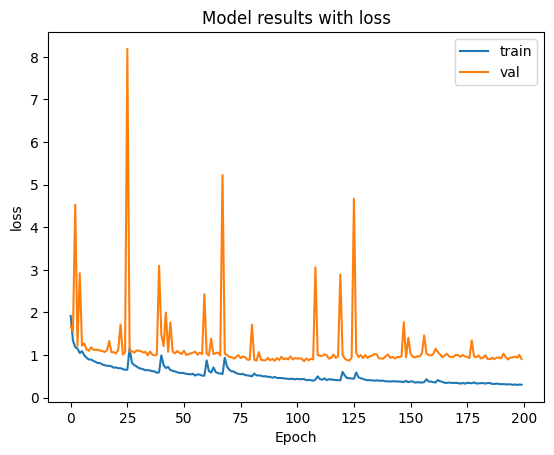

In [59]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'metric_1')

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

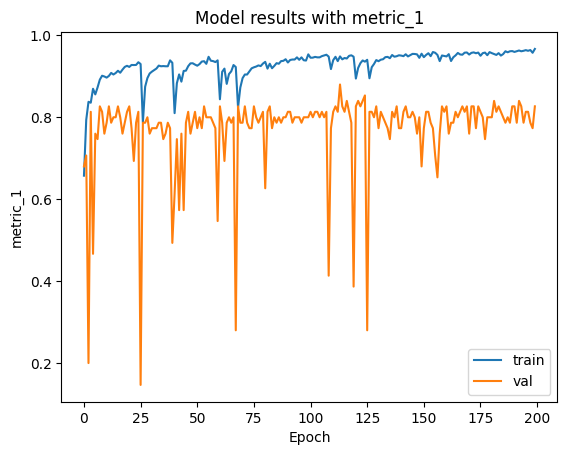

In [60]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'metric_1')

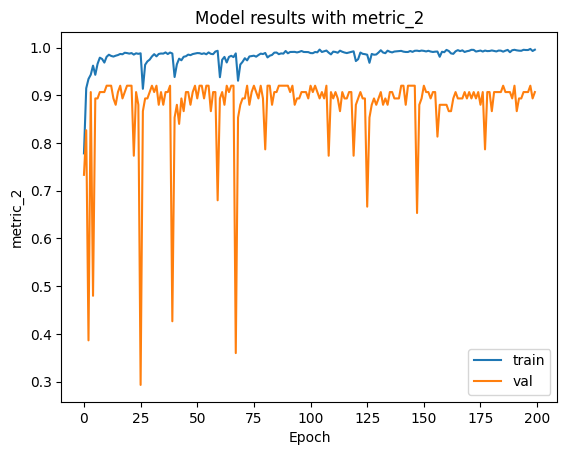

In [61]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'metric_2')

[]

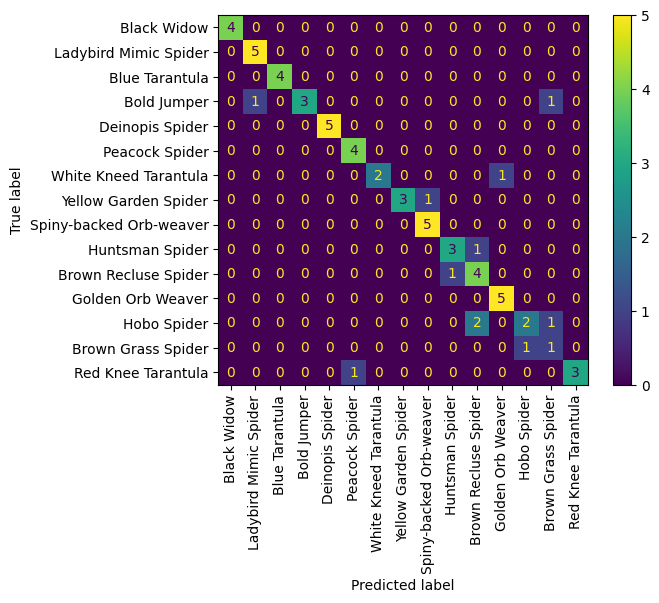

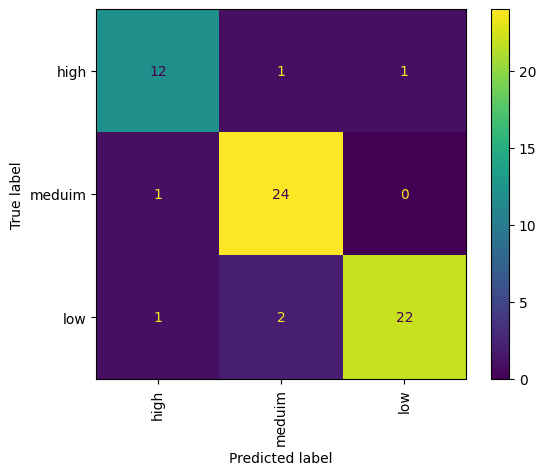

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')
model.eval()
x_test, y_test = next(iter(test_loader))

y_pred = model.predict(x_test)

y_pred_1 = y_pred[0].numpy()
y_pred_2 = y_pred[1].numpy()

ConfusionMatrixDisplay.from_predictions(y_test[0], y_pred_1, display_labels = list_of_classes)
plt.xticks(rotation=90)
plt.plot()


ConfusionMatrixDisplay.from_predictions(y_test[1], y_pred_2, display_labels = danger_level)
plt.xticks(rotation=90)
plt.plot()
